<a href="https://colab.research.google.com/github/caioatila89/tcc-bimaster/blob/main/TwitterNYTimes_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Análise de Sentimentos dos tweets publicados pelo jornal americam The New York Times**

Desenvolvimento do Projeto de Conclusão de Curso da Pós-Graduação BI-Master da PUC-Rio lecionada pelo Laboratório ICA
Os objetivos a serem atingidos são:
*   Extrair dados do @NYTimes usando tokens disponibilizados pelo twitter após a criação de conta de desenvolvedor
*   Realizar pré-processamento dos tweets
*   Coletar subjetividade e polaridade dos tweets com a biblioteca TextBlob e NLTK
*   Plotar gráficos
*   Gerar Wordcloud

**Passo 1: Importação das bibliotecas**

In [ ]:
import tweepy
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
!python -m spacy download en_core_web_md
!python -m spacy link en_core_web_md en --force
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
!pip install contractions
from contractions import contractions_dict
import unicodedata
from textblob import TextBlob
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


     |████████████████████████████████| 96.4MB 1.2MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp37-none-any.whl size=98051305 sha256=cbabec78cabe954d58e1c1ca10040e4d48d6c5a8102003de3971e73ede8df06e
  Stored in directory: /tmp/pip-ephem-wheel-cache-pfu608z9/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_md -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 266kB 4.1MB/s 
     |████████████████████████████████| 327kB 44.2MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85396 sha256=801338abf1d9505594bc47dda41059c8e78af8787ecec3333d6538874229a1ef
  Stored in directory: /root/.cache/pip/wheels/3a

**Passo 2: Declaração dos tokens de acesso disponibilizados pelo twitter após criação da conta de desenvolvedor.**

In [ ]:
access_token = "37071881-Zam270suxYTZWb46B16Wi4EBrHRcUpubRNTz5LSBa"
access_token_secret = "m4PcAsq8adXsPRl5u03muiBgULRbpn9lw7QKTTSqT6LS1"
consumer_key = "FiN9LtB3lhdaC5Iej2XVlBoqk"
consumer_secret = "YCTnCds8pw310oePnpw1I7AqCjMqfclpBp0rPvoEy5MOu52Fs6"

**Passo 3: Logar com a conta de desenvolvedor utilizando a biblioteca Tweepy, extrair os últimos 300 tweets postados pelo @nytimes, obtendo o texto do tweet, número de likes, número de retweets e localização. Por fim, incluir as informações em um dataframe.**

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)
tweets=api.user_timeline(screen_name="nytimes",count=300,tweet_mode="extended")

In [ ]:
df = pd.DataFrame([tweet.full_text for tweet in tweets], columns = ['tweet'])
df['nlikes'] = pd.array([tweet.favorite_count for tweet in tweets])
df['nretweets'] = pd.array([tweet.retweet_count for tweet in tweets])
df['localização'] = pd.array([tweet.user.location for tweet in tweets])
df.head()

,tweet,nlikes,nretweets,localização
0,RT @joncaramanica: spent the last few months c...,0,27,New York City
1,New York can begin vaccinating people 30 and o...,222,34,New York City
2,"The ""Temple of Vaccinia,"" where, more than 220...",137,31,New York City
3,Inside the battle over George Floyd Square in ...,138,29,New York City
4,"Jena Scurry, a 911 dispatcher who watched poli...",971,282,New York City


**Passo 4: Pré-processamento dos tweets para remover stopwords, caracteres especiais e links.**

In [ ]:
def limpartexto(texto):
    texto = re.sub(r'@[\w]+','',texto)
    texto = re.sub(r'#','',texto)
    texto = re.sub(r'RT[\s]+','',texto)
    texto = re.sub(r'https?:\/\/\S+', '', texto)
    return texto
df['tweet'] = df['tweet'].apply(limpartexto)

In [ ]:
nlp = spacy.load('en')
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
stopword_list.append('pic.twitter.com')
stopword_list.append('pic')
stopword_list.append('new')
stopword_list.append('said')
stopword_list.append('says')
stopword_list.append('twitter')

In [ ]:
def remover_stopwords(texto):
  tokens = tokenizer.tokenize(texto)
  tokens = [token.strip() for token in tokens]
  token_filtrado = [token for token in tokens if token.lower() not in stopword_list]
  texto_filtrado = ' '.join(token_filtrado)
  return texto_filtrado

df['tweet'] = df['tweet'].apply(remover_stopwords)

def remover_caracteres(texto, remover_digitos=False):
  caract_especial = re.compile(r'([{.(-)!}])')
  texto = caract_especial.sub(" \\1 ", texto)

  padrao = r'[^a-zA-z0-9\s]'
  texto = re.sub(padrao, '', texto)
  return texto
df['tweet'] = df['tweet'].apply(remover_caracteres)

**Passo 5: Coletar subjetividade e polaridade utilizando a biblioteca TextBlob e classificar como positivo, negativo ou neutro.**

In [ ]:
def Subjetividade(texto):
    blob = TextBlob(texto)
    return blob.sentiment.subjectivity
def Polaridade(texto):
    blob = TextBlob(texto)
    return blob.sentiment.polarity

In [ ]:
df['Subjetividade'] = df['tweet'].apply(Subjetividade)
df['Polaridade'] = df['tweet'].apply(Polaridade)

In [ ]:
def analise_de_sentimento(score):
    if score < 0:
        return 'Negativo'
    elif score == 0:
        return 'Neutro'
    else:
        return 'Positivo'

In [ ]:
df['Sentimento'] = df['Polaridade'].apply(analise_de_sentimento)

In [ ]:
df.head(20)

,tweet,nlikes,nretweets,localização,Subjetividade,Polaridade,Sentimento
0,spent last months checking Action Bronson hit...,0,27,New York City,0.088889,0.000000,Neutro
1,York begin vaccinating people 30 older Tuesday...,222,34,New York City,0.316667,0.133333,Positivo
2,Temple Vaccinia 220 years ago residents E...,137,31,New York City,0.111111,0.083333,Positivo
3,Inside battle George Floyd Square Minneapolis,138,29,New York City,0.000000,0.000000,Neutro
4,Jena Scurry 911 dispatcher watched police pin...,971,282,New York City,0.400000,-0.050000,Negativo
5,Breaking News President Biden urged states re...,624,173,New York City,0.500000,0.000000,Neutro
6,27yearold man shot killed parents two people ...,231,90,New York City,0.200000,-0.050000,Negativo
7,one goes frosting lovers,224,33,New York City,0.000000,0.000000,Neutro
8,vice president Joe Biden oversaw green jobs ...,277,55,New York City,0.533333,0.055556,Positivo
9,Doc Severinsen trumpeter former Tonight Show ...,201,29,New York City,0.075000,0.000000,Neutro


**Passo 6: Contabilizar tweets por classificação de sentimento e plotar gráfico.**

In [ ]:
contsentiment = df.groupby('Sentimento').tweet.count()
contsentiment

Sentimento
Negativo    51
Neutro      72
Positivo    77
Name: tweet, dtype: int64

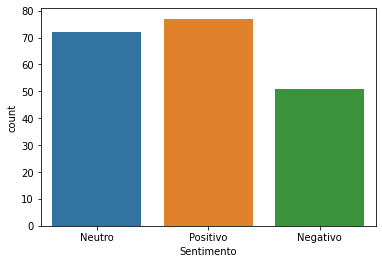

In [ ]:
sns.countplot(x="Sentimento", data=df)

**Passo 7: Plotar boxplot**

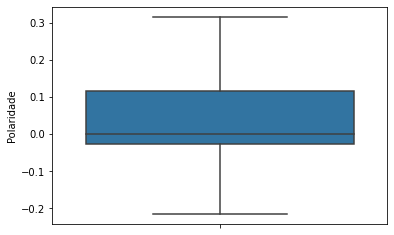

In [ ]:
sns.boxplot(y='Polaridade', data=df, showfliers = False)

**Passo 8: Adicionar ao dataframe uma coluna com a quantidade de caracteres por tweet para verificar sua distribuição.**

In [ ]:
df['caract_tweet'] = df['tweet'].apply(len)

In [ ]:
df.head(20)

,tweet,nlikes,nretweets,localização,Subjetividade,Polaridade,Sentimento,caract_tweet
0,spent last months checking Action Bronson hit...,0,27,New York City,0.088889,0.000000,Neutro,85
1,York begin vaccinating people 30 older Tuesday...,222,34,New York City,0.316667,0.133333,Positivo,111
2,Temple Vaccinia 220 years ago residents E...,137,31,New York City,0.111111,0.083333,Positivo,161
3,Inside battle George Floyd Square Minneapolis,138,29,New York City,0.000000,0.000000,Neutro,45
4,Jena Scurry 911 dispatcher watched police pin...,971,282,New York City,0.400000,-0.050000,Negativo,181
5,Breaking News President Biden urged states re...,624,173,New York City,0.500000,0.000000,Neutro,138
6,27yearold man shot killed parents two people ...,231,90,New York City,0.200000,-0.050000,Negativo,116
7,one goes frosting lovers,224,33,New York City,0.000000,0.000000,Neutro,26
8,vice president Joe Biden oversaw green jobs ...,277,55,New York City,0.533333,0.055556,Positivo,186
9,Doc Severinsen trumpeter former Tonight Show ...,201,29,New York City,0.075000,0.000000,Neutro,144


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


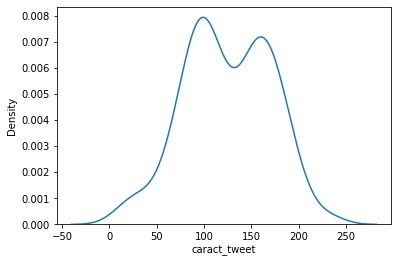

In [ ]:
sns.distplot(df.caract_tweet, hist=False)

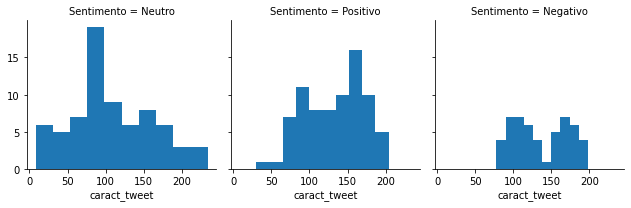

In [ ]:
g = sns.FacetGrid(df,col='Sentimento')
g.map(plt.hist,'caract_tweet')

**Passo 9: Identificar palavras mais comuns nos tweets.**

       Palavra  Frequência
0       people          36
1         york          20
2          not          19
3          one          16
4        floyd          14
5         ship          13
6  coronavirus          12
7       george          12
8        canal          12
9        derek          11


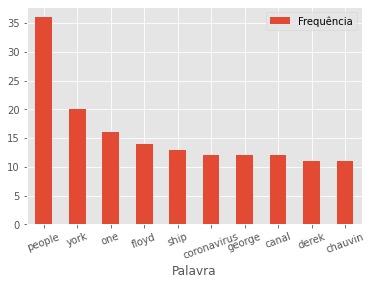

In [ ]:
top_N = 10

txt = df.tweet.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
palavras = nltk.tokenize.word_tokenize(txt)
palavra_dist = nltk.FreqDist(palavras)

stopwords = nltk.corpus.stopwords.words('english')
palavras_excecao = nltk.FreqDist(w for w in palavras if w not in stopwords) 

rslt = pd.DataFrame(palavra_dist.most_common(top_N),
                    columns=['Palavra', 'Frequência'])
print(rslt)
rslt = pd.DataFrame(palavras_excecao.most_common(top_N),
                    columns=['Palavra', 'Frequência']).set_index('Palavra')

matplotlib.style.use('ggplot')

rslt.plot.bar(rot=20)

**Passo 10: Gerar Wordcloud**

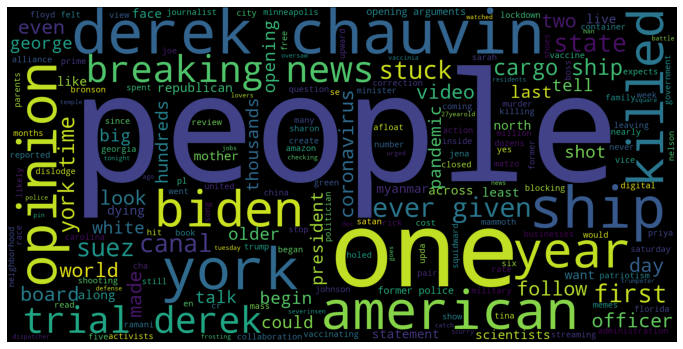

In [ ]:
texto = df['tweet'].to_string().lower() 
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='black', width=1600,                            
                      height=800).generate(texto)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Passo 11: Classificar os sentimentos utilizando a biblioteca NLTK**

In [ ]:
sentimento_nltk = []
sentimento_nltk_classif = []
sid = SentimentIntensityAnalyzer()

for tweet in df.tweet:
  nltk_score = sid.polarity_scores(tweet).get('compound')
  sentimento_nltk.append(nltk_score)
  sentimento_nltk_classif.append('Positivo' if nltk_score>0 else 'Neutro' if nltk_score == 0 else 'Negativo')
df['Sentimento NLTK'] = sentimento_nltk 
df['NLTK Classe'] = sentimento_nltk_classif
df.head(15)

,tweet,nlikes,nretweets,localização,Subjetividade,Polaridade,Sentimento,caract_tweet,Sentimento NLTK,NLTK Classe
0,spent last months checking Action Bronson hit...,0,27,New York City,0.088889,0.000000,Neutro,85,-0.3818,Negativo
1,York begin vaccinating people 30 older Tuesday...,222,34,New York City,0.316667,0.133333,Positivo,111,0.0000,Neutro
2,Temple Vaccinia 220 years ago residents E...,137,31,New York City,0.111111,0.083333,Positivo,161,-0.4215,Negativo
3,Inside battle George Floyd Square Minneapolis,138,29,New York City,0.000000,0.000000,Neutro,45,-0.3818,Negativo
4,Jena Scurry 911 dispatcher watched police pin...,971,282,New York City,0.400000,-0.050000,Negativo,181,0.0000,Neutro
5,Breaking News President Biden urged states re...,624,173,New York City,0.500000,0.000000,Neutro,138,-0.4019,Negativo
6,27yearold man shot killed parents two people ...,231,90,New York City,0.200000,-0.050000,Negativo,116,-0.6705,Negativo
7,one goes frosting lovers,224,33,New York City,0.000000,0.000000,Neutro,26,0.5267,Positivo
8,vice president Joe Biden oversaw green jobs ...,277,55,New York City,0.533333,0.055556,Positivo,186,-0.5267,Negativo
9,Doc Severinsen trumpeter former Tonight Show ...,201,29,New York City,0.075000,0.000000,Neutro,144,0.0000,Neutro


**Passo 12: Contabilizar tweets por classificação de sentimento e plotar gráfico.**

In [ ]:
sentnltk = df.groupby('NLTK Classe').tweet.count()
sentnltk

NLTK Classe
Negativo    90
Neutro      47
Positivo    63
Name: tweet, dtype: int64

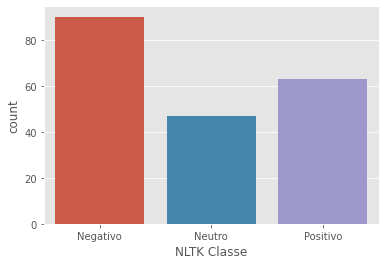

In [ ]:
sns.countplot(x ='NLTK Classe', data=df)

**Passo 13: Plotar boxplot**

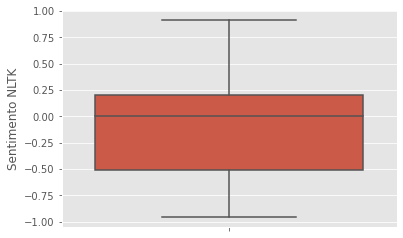

In [ ]:
sns.boxplot(y='Sentimento NLTK', data=df, showfliers = False)

**Passo 14: Plotar gráfico de dispersão da média de retweets x sentimento**

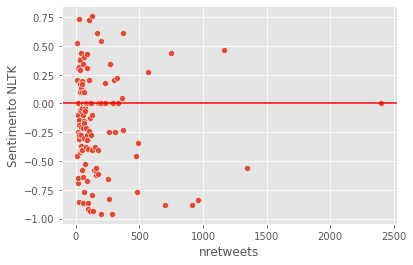

In [ ]:
media_retweets = df.groupby('nretweets').mean()
sns.scatterplot(x=media_retweets.index, y="Sentimento NLTK", data=media_retweets)
plt.axhline(y=0, color='r', linestyle='-');

**Passo 15: Plotar gráfico de dispersão da média de likes x sentimento**

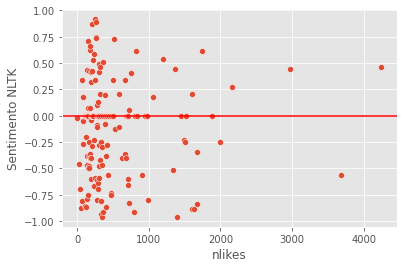

In [ ]:
media_likes = df.groupby('nlikes').mean()
sns.scatterplot(x=media_likes.index, y="Sentimento NLTK", data=media_likes)
plt.axhline(y=0, color='r', linestyle='-');